# POWERCO CUSTOMER CHURN ANALYSIS

## BACKGROUND

PowerCo, a leading utility provider in the gas and electricity sector, primarily serves small and medium-sized enterprises (SMEs). In recent years, the energy market has experienced significant transformations, introducing a multitude of choices for customers. This competitive landscape has heightened the risk of customer attrition, commonly referred to as "churn," where customers leave PowerCo for more attractive offers from rival energy providers.

PowerCo has identified this rising churn as a critical challenge, prompting them to engage Boston Consulting Group (BCG) to diagnose the underlying causes. One potential factor discussed during preliminary meetings is the sensitivity of customers to pricing. Understanding how much the price influences a customer's decision to stay with or leave PowerCo will be essential in developing strategies to retain their customer base in this increasingly competitive market

The client has sent over 3 data sets :-
1. HSTORICAL CUSTOMER DATA (Customer data such as usage, sign up date, forecasted usage etc)
2. HISTORICAL PRICING DATA (variable and fixed pricing data etc)
3. CHURN INDICATOR (Whether the customer has churned)

## ANALYSIS

### IMPORTING NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from IPython.display import display
import statsmodels.api as sm
from lifelines import CoxPHFitter
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### FUNCTION FOR COUNTPLOT ACCORDING TO A CATEGORY

In [ ]:
def countplot(data, categories, c, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(14, 10))
    ax = np.atleast_2d(ax)
    for i, cat in enumerate(categories):
        row, col = divmod(i, cols)
        plot = sns.countplot(data=data, x=cat, hue= c , palette='viridis', ax=ax[row, col])
        ax[row, col].set_title(f"Distribution by {cat}", fontsize=14)
        ax[row, col].set_xlabel(cat, fontsize=12)
        ax[row, col].set_ylabel('Count', fontsize=12)
        ax[row, col].tick_params(axis='x', rotation=45)
        total_counts = data[cat].value_counts().sum()
        for p in plot.patches:
            height = p.get_height()
            if height > 0:
                percentage = height
                ax[row, col].annotate(percentage,
                                      (p.get_x() + p.get_width() / 2, height),
                                      ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')
    if len(categories) < rows * cols:
        ax[-1, -1].axis('off')
    plt.tight_layout()
    plt.show()

### FUNCTION FOR HISTOGRAM PLOT ACCORDING TO CATEGORY

In [ ]:
def histplot(data, forecast = None, cat = None, rows = None, cols = None):
    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    ax = np.atleast_2d(ax)
    for i in range(len(forecast)):
        row, col = divmod(i, cols)
        sns.histplot(data=data, x=data.columns[forecast[i]], kde=True, hue=cat, ax=ax[row, col])
        ax[row, col].set_title(f'Histogram of {data.columns[forecast[i]]}', fontsize=14)
        ax[row, col].set_xlabel(data.columns[forecast[i]], fontsize=12)
        ax[row, col].set_ylabel('Count', fontsize=12)
        ax[row, col].tick_params(axis='x', rotation=45)
        if len(forecast) < rows * cols:
            ax[-1, -1].axis('off')
    plt.tight_layout()
    plt.show()

### FUNCTION OF BOXPLOT ACCORDING TO CATEGORY

In [ ]:
def jitter_box_plot(data, feature_indices, category=None, cat=None, rows=None, cols=None):
    fig, ax = plt.subplots(rows, cols, figsize=(10, 4 * rows))
    ax = np.atleast_2d(ax)

    for i, idx in enumerate(feature_indices):
        row, col = divmod(i, cols)
        sns.boxplot(data=data, x=data.columns[idx], y=category, hue=cat, ax=ax[row, col], showcaps=True,
                    boxprops=dict(facecolor='none', edgecolor='black'), whiskerprops=dict(color='black'),
            capprops=dict(color='black'), medianprops=dict(color='black'), showfliers=False, dodge=True )

        sns.stripplot( data=data, x=data.columns[idx], y=category, hue=cat, ax=ax[row, col], jitter=0.25, alpha=0.5,
            dodge=True, marker='o', linewidth=0.5, edgecolor='auto')

        ax[row, col].set_title(f' Plot of {data.columns[idx]}', fontsize=14)
        ax[row, col].set_xlabel(data.columns[idx], fontsize=12)
        ax[row, col].tick_params(axis='x', rotation=45)

        handles, labels = ax[row, col].get_legend_handles_labels()
        if i == 0:
            ax[row, col].legend(handles, labels)
        else:
            ax[row, col].legend_.remove()
    if len(feature_indices) < rows * cols:
        for j in range(len(feature_indices), rows * cols):
            row, col = divmod(j, cols)
            ax[row, col].axis('off')

    plt.tight_layout()
    plt.show()


## PRICE DATA

In [ ]:
price = pd.read_csv("price.csv")
price

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,1/1/2015,0.151367,0.000000,0.000000,44.266931,0.00000,0.000000
1,038af19179925da21a25619c5a24b745,2/1/2015,0.151367,0.000000,0.000000,44.266931,0.00000,0.000000
2,038af19179925da21a25619c5a24b745,3/1/2015,0.151367,0.000000,0.000000,44.266931,0.00000,0.000000
3,038af19179925da21a25619c5a24b745,4/1/2015,0.149626,0.000000,0.000000,44.266931,0.00000,0.000000
4,038af19179925da21a25619c5a24b745,5/1/2015,0.149626,0.000000,0.000000,44.266931,0.00000,0.000000
...,...,...,...,...,...,...,...,...
192997,16f51cdc2baa19af0b940ee1b3dd17d5,8/1/2015,0.119916,0.102232,0.076257,40.728885,24.43733,16.291555
192998,16f51cdc2baa19af0b940ee1b3dd17d5,9/1/2015,0.119916,0.102232,0.076257,40.728885,24.43733,16.291555
192999,16f51cdc2baa19af0b940ee1b3dd17d5,10/1/2015,0.119916,0.102232,0.076257,40.728885,24.43733,16.291555
193000,16f51cdc2baa19af0b940ee1b3dd17d5,11/1/2015,0.119916,0.102232,0.076257,40.728885,24.43733,16.291555


- id = client company identifier
- price_date = reference date
- price_off_peak_var = price of energy for the 1st period (off peak)
- price_peak_var = price of energy for the 2nd period (peak)
- price_mid_peak_var = price of energy for the 3rd period (mid peak)
- price_off_peak_fix = price of power for the 1st period (off peak)
- price_peak_fix = price of power for the 2nd period (peak)
- price_mid_peak_fix = price of power for the 3rd period (mid peak)

**The Price variables are given for the 1st day of each month for the year 2015. For each customer the price variables are given for the 1st day 12 months respectively.**

**So the price information for each client can be aggregated. Since the price data is for a single year 2015, the mean, standard deviation, maximum and range of the power and energy prices over the months are calculated since these metrices are relevant from business perspective.**

In [ ]:
def price_change(x):
    return x.iloc[-1] - x.iloc[0]

agg_features_org = price.groupby("id").agg({
    "price_off_peak_var": ["mean", "std", "max", price_change],
    "price_peak_var": ["mean", "std", "max", price_change],
    "price_mid_peak_var": ["mean", "std", "max", price_change],
    "price_off_peak_fix": ["mean", "std", "max", price_change],
    "price_peak_fix": ["mean", "std", "max", price_change],
    "price_mid_peak_fix": ["mean", "std", "max", price_change]
}).reset_index()

agg_features_org.columns = [
    "id",
    "off_energy_mean", "off_energy_std", "off_energy_max", "off_energy_price_change",
    "peak_mean", "peak_std", "peak_max", "peak_price_change",
    "mid_peak_mean", "mid_peak_std", "mid_peak_max", "mid_peak_price_change",
    "off_power_mean", "off_power_std", "off_power_max", "off_power_price_change",
    "peak_fix_mean", "peak_fix_std", "peak_fix_max", "peak_fix_price_change",
    "mid_fix_mean", "mid_fix_std", "mid_fix_max", "mid_fix_price_change"
]

agg_features = agg_features_org.copy()

**A new dataframe agg_features_org is created with the aggregate columns of mean and standard deviation and maximum of prices for each client and a copy of the agg_features_org is also cretaed for further analysis**

In [ ]:
agg_features.describe()

,off_energy_mean,off_energy_std,off_energy_max,off_energy_price_change,peak_mean,peak_std,peak_max,peak_price_change,mid_peak_mean,mid_peak_std,...,off_power_max,off_power_price_change,peak_fix_mean,peak_fix_std,peak_fix_max,peak_fix_price_change,mid_fix_mean,mid_fix_std,mid_fix_max,mid_fix_price_change
count,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,...,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,0.141022,0.004234,0.145316,-0.004545,0.054636,0.002620,0.059323,-0.000976,0.030503,0.001252,...,43.620663,0.279544,10.625528,0.293074,10.797482,-0.048744,6.411368,0.181335,6.524310,-0.028724
std,0.024184,0.005247,0.025228,0.012778,0.049505,0.006218,0.050305,0.011173,0.036016,0.004562,...,5.389714,1.432820,12.756070,1.530557,12.896821,2.338325,7.718998,0.947342,7.819601,1.463097
min,0.000000,0.000000,0.000000,-0.148477,0.000000,0.000000,0.000000,-0.143815,0.000000,0.000000,...,0.000000,-44.266931,0.000000,0.000000,0.000000,-36.344726,0.000000,0.000000,0.000000,-16.724389
25%,0.124068,0.002185,0.128067,-0.008161,0.000000,0.000000,0.000000,-0.003317,0.000000,0.000000,...,40.728885,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.147251,0.003220,0.149555,-0.005610,0.085936,0.001419,0.087421,0.000000,0.000000,0.000000,...,44.444710,0.162916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.150171,0.004310,0.153048,-0.003573,0.102290,0.002147,0.104660,0.000000,0.072525,0.000889,...,44.444710,0.177779,24.388455,0.044209,24.437330,0.097749,16.248109,0.025367,16.291555,0.065166
max,0.278759,0.068978,0.280700,0.168958,0.196275,0.069626,0.229788,0.148474,0.102952,0.051097,...,59.444710,40.728885,36.490692,17.941261,36.490692,36.490689,16.818917,8.646453,17.458221,16.791555


**It can be seen that there are clients with zero peak energy prices. Since price during peak hours may significantly impact customer satisfaction, peak prices holds good business significance. Their prices should be analyzed**

In [ ]:
agg_features[agg_features['peak_max'] == 0].describe()

,off_energy_mean,off_energy_std,off_energy_max,off_energy_price_change,peak_mean,peak_std,peak_max,peak_price_change,mid_peak_mean,mid_peak_std,...,off_power_max,off_power_price_change,peak_fix_mean,peak_fix_std,peak_fix_max,peak_fix_price_change,mid_fix_mean,mid_fix_std,mid_fix_max,mid_fix_price_change
count,6620.000000,6620.000000,6620.000000,6620.000000,6620.0,6620.0,6620.0,6620.0,6620.0,6620.0,...,6620.000000,6620.000000,6620.0,6620.0,6620.0,6620.0,6620.0,6620.0,6620.0,6620.0
mean,0.149366,0.003358,0.152570,-0.002582,0.0,0.0,0.0,0.0,0.0,0.0,...,43.959138,0.381885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.024970,0.005757,0.026912,0.014317,0.0,0.0,0.0,0.0,0.0,0.0,...,6.124790,1.437887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,-0.148477,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,-44.266931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.147554,0.002020,0.149902,-0.005150,0.0,0.0,0.0,0.0,0.0,0.0,...,44.444710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.149179,0.002207,0.151367,-0.003778,0.0,0.0,0.0,0.0,0.0,0.0,...,44.444710,0.177779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.150285,0.002671,0.152445,-0.003396,0.0,0.0,0.0,0.0,0.0,0.0,...,44.444710,0.177779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.278759,0.068978,0.280700,0.145627,0.0,0.0,0.0,0.0,0.0,0.0,...,59.444710,29.326930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Those with zero peak energy prices alsohave zero mid peak energy prices and zero peak and mid peak power prices**

In [ ]:
agg_features[agg_features['peak_fix_max'] == 0].describe()

,off_energy_mean,off_energy_std,off_energy_max,off_energy_price_change,peak_mean,peak_std,peak_max,peak_price_change,mid_peak_mean,mid_peak_std,...,off_power_max,off_power_price_change,peak_fix_mean,peak_fix_std,peak_fix_max,peak_fix_price_change,mid_fix_mean,mid_fix_std,mid_fix_max,mid_fix_price_change
count,9330.000000,9330.000000,9330.000000,9330.000000,9330.000000,9330.000000,9330.000000,9330.000000,9330.000000,9.330000e+03,...,9330.000000,9330.000000,9330.0,9330.0,9330.0,9330.0,9330.0,9330.0,9330.0,9330.0
mean,0.154032,0.003499,0.157362,-0.002519,0.020025,0.002157,0.025778,0.000981,0.000102,9.378602e-07,...,44.169012,0.371110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.023431,0.005777,0.025508,0.014259,0.036446,0.006690,0.040582,0.009953,0.002723,2.886545e-05,...,5.200364,1.329615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,-0.148477,0.000000,0.000000,0.000000,-0.087658,0.000000,0.000000e+00,...,0.000000,-44.266931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.148045,0.002020,0.150211,-0.005164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,44.444710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.149855,0.002240,0.152062,-0.003778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,44.444710,0.177779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.165418,0.002769,0.168184,-0.003045,0.007124,0.000487,0.085450,0.000000,0.000000,0.000000e+00,...,44.444710,0.177779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.278759,0.068978,0.280700,0.168958,0.196275,0.060407,0.196782,0.117311,0.073987,1.644655e-03,...,59.444710,29.326930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**-THERE ARE SOME CLIENTS WITH FREE PEAK AND MID PEAK PRICES. OFF PEAK PRICES ARE ALWAYS NON ZERO.**

**-THERE ARE SOME CLIENTS WHO HAVE BOTH FREE PEAK POWER AND ENERGY PRICES.**

**-THERE ARE FEW CLIENTS WHO HAVE FREE MID PEAK ENERGY PRICE BUT NOT FREE PEAK ENERGY PRICE.**

**-IF PEAK ENERGY PRICES ARE FREE THEN MID PEAK ENERGY, PEAK POWER AND MID PEAK POWER ARE ALSO FREE.**

**-EXCEPT PEAK ENERGY PRICES OTHER PEAK AND MID PEAK PRICES ZERO DOES NOT IMPLY PEAK ENERGY PRICE IS ZERO**

## CLIENT DATA

In [ ]:
client_data = pd.read_csv("client.csv")
client = client_data.copy()

- id = client company identifier
- channel_sales = code of the sales channel
- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month
- date_activ = date of activation of the contract
- date_end = registered date of the end of the contract
- date_modif_prod = date of the last modification of the product
- date_renewal = date of the next contract renewal
- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year
- forecast_discount_energy = forecasted value of current discount
- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months
- forecast_price_energy_off_peak = forecasted energy price for 1st period (off peak)
- forecast_price_energy_peak = forecasted energy price for 2nd period (peak)
- forecast_price_pow_off_peak = forecasted power price for 1st period (off peak)
- has_gas = indicated if client is also a gas client
- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)
- origin_up = code of the electricity campaign the customer first subscribed to
- pow_max = subscribed power
- churn = has the client churned over the next 3 months

**The difference between forecasted and current peak time energy price is taken and converted into a categorical column since the variabilty of the difference was very low. So converting it into a categorical column is appropriate. Same is done for off peak electricity price and off peak energy price.**

In [ ]:
p = pd.merge(agg_features, client, on = 'id')

In [ ]:
cols = [5, 7, 8, 9, 11, 12]
p.iloc[:,cols].describe()

,peak_mean,peak_max,peak_price_change,mid_peak_mean,mid_peak_max,mid_peak_price_change
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,0.052063,0.056767,-0.000827,0.028276,0.029156,0.000480
std,0.049879,0.050822,0.010844,0.035802,0.036800,0.007119
min,0.000000,0.000000,-0.143815,0.000000,0.000000,-0.098720
25%,0.000000,0.000000,-0.002904,0.000000,0.000000,0.000000
50%,0.084510,0.085483,0.000000,0.000000,0.000000,0.000000
75%,0.102479,0.104841,0.000000,0.072833,0.073873,0.000718
max,0.196275,0.229788,0.148474,0.102952,0.114102,0.103502


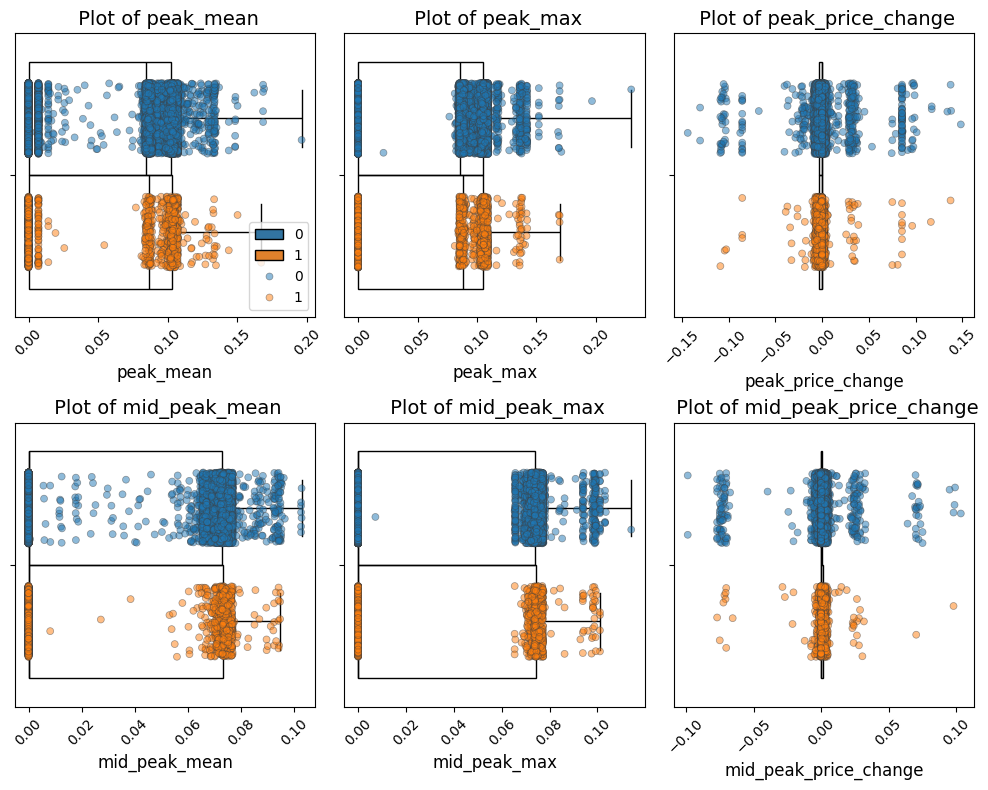

In [ ]:
cols = [5, 7, 8, 9, 11, 12]
jitter_box_plot(data = p, feature_indices = cols, category = None, cat = 'churn', rows = 2, cols = 3)

#### ***ENERGY PRICES PATTERN***

1) **CLIENTS WITH NON ZERO PEAK PRICES HAVE VERY SPARSE PEAK PRICE CHANGE AND PRICE CHANGE IS WITHIN A SPECIFIC RANGE OF +- 0.15. SO IT CAN BE CONVERTED TO BOOLEAN COLUMN OF WHETHER PEAK PRICE HAS INCREASED, DECREASED OR REMAINED SAME. SAME IS FOR MID PEAK PRICE CHANGE**

2) **STANDARD DEVIATION OF PEAK ENERGY PRICE IS VERY SPARSE AND IT IS BETTER TO DROP**

3) **IT CAN BE NOTICED THAT THOSE WHO HAVE NOT FREE MID PEAK ENERGY PRICES HAVE PEAK PRICES SLIGHT LOWER THAN THOSE WITH FREE PEAK ENERGY PRICES**

In [ ]:
def get_kmeans_thresholds(data, column, n_clusters=3):
    x = data[column].dropna().values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    kmeans.fit(x)
    sorted_centroids = np.sort(kmeans.cluster_centers_.flatten())
    thresholds = [(sorted_centroids[i] + sorted_centroids[i+1]) / 2 for i in range(n_clusters - 1)]
    print(f'"{column} cluster thresholds"\n{thresholds}')

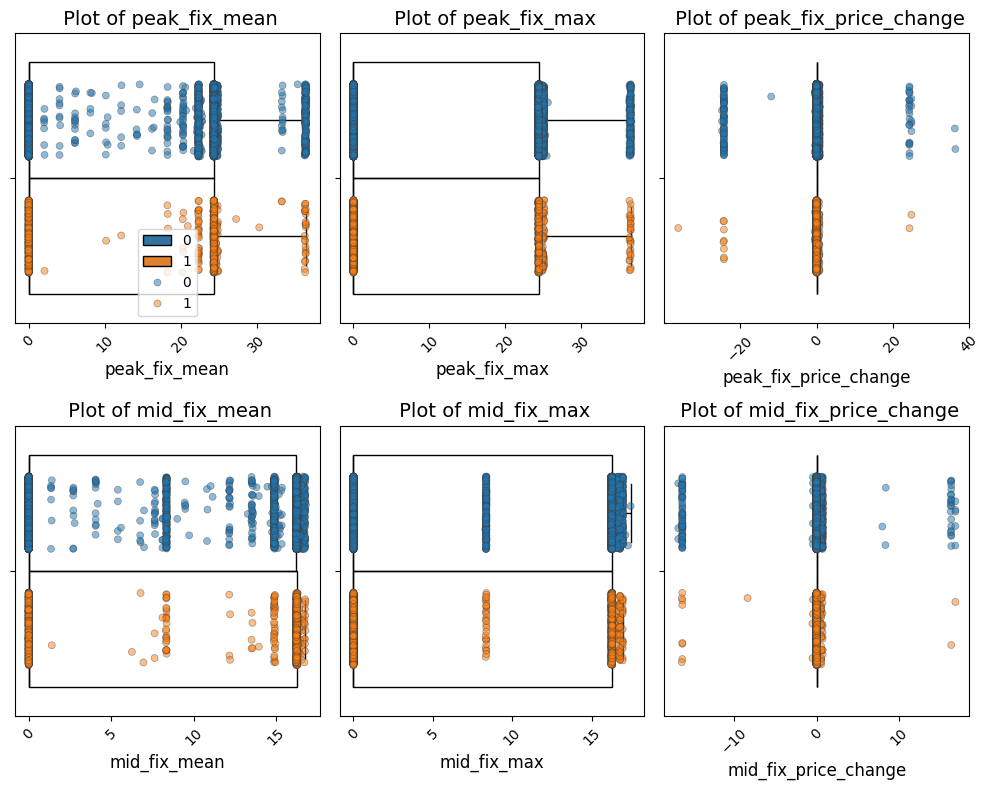

In [ ]:
cols = [17, 19, 20, 21, 23, 24]
jitter_box_plot(data = p, feature_indices = cols, category = None, cat = 'churn', rows = 2, cols = 3)

#### ***POWER PRICES PATTERN***

1) **POSSIBLE BINNING OF PEAK AND MID PEAK POWER PRICES COULD BE DONE AS "FREE", "MED" OR "HIGH"**

2) **POWER PRICES CHANGE COULD BE CONVERTED TO BOOLEAN AS "INC", "DEC" OR "SAME"**

3) **FOR POWER PRICES MEAN POWER PRICE PATTERN AND MAX POWER PRICE PATTERN ARE QUITE SAME AND EITHER OF THEM COULD BE RETAINED. MEAN PRICES COULD BE RETAINED AND BINNING COULD BE DONE ACCORDINGLY**

In [ ]:
get_kmeans_thresholds(p, 'peak_mean', 4)
get_kmeans_thresholds(p, 'mid_peak_mean', 4)

"peak_mean cluster thresholds"
[np.float64(0.043614243743435324), np.float64(0.09493116531465307), np.float64(0.1177462633605974)]
"mid_peak_mean cluster thresholds"
[np.float64(0.03264683043620623), np.float64(0.06943591737037737), np.float64(0.08267364211389479)]


In [ ]:
get_kmeans_thresholds(p, 'peak_fix_mean', 4)
get_kmeans_thresholds(p, 'mid_fix_mean', 4)

"peak_fix_mean cluster thresholds"
[np.float64(10.758524643333729), np.float64(22.94726493682944), np.float64(30.281333563401812)]
"mid_fix_mean cluster thresholds"
[np.float64(4.124865772874061), np.float64(11.403147619033557), np.float64(15.421378354971418)]


In [ ]:
p['peak_energy_price_change'] = np.where(p['peak_price_change'] > 0, "Inc", np.where(p['peak_price_change'] < 0, "Dec", "Same"))
p['mid_peak_energy_price_change'] = np.where(p['mid_peak_price_change'] > 0, "Inc", np.where(p['mid_peak_price_change'] < 0, "Dec", "Same"))
p['peak_power_price_change'] = np.where(p['peak_fix_price_change'] > 0, "Inc", np.where(p['peak_fix_price_change'] < 0, "Dec", "Same"))
p['mid_peak_power_price_change'] = np.where(p['mid_fix_price_change'] > 0, "Inc", np.where(p['mid_fix_price_change'] < 0, "Dec", "Same"))

In [ ]:
p['peak_energy_price_level'] = np.where(p['peak_mean'] == 0, 'FREE', np.where(p['peak_mean'] < 0.095, 'LOW', np.where(p['peak_mean'] < 0.118, 'MEDIUM', 'HIGH')))
p['mid_peak_energy_price_level'] = np.where(p['mid_peak_mean'] == 0, 'FREE', np.where(p['mid_peak_mean'] < 0.0694, 'LOW', np.where(p['mid_peak_mean'] < 0.083, 'MEDIUM', 'HIGH')))
p['peak_power_price_level'] = np.where(p['peak_fix_mean'] == 0, 'FREE', np.where(p['peak_fix_mean'] < 22.95, 'LOW', np.where(p['peak_fix_mean'] < 30.28, 'MEDIUM', 'HIGH')))
p['mid_peak_power_price_level'] = np.where(p['mid_fix_mean'] == 0, 'FREE', np.where(p['mid_fix_mean'] < 11.40, 'LOW', np.where(p['mid_fix_mean'] < 15.42, 'MEDIUM', 'HIGH')))

In [ ]:
# Define ordinal maps
level_map = {'FREE': 0, 'LOW': 1, 'MEDIUM': 2, 'HIGH': 3}
change_map = {'Dec': -1, 'Same': 0, 'Inc': 1}

# Overwrite price level columns
p['peak_energy_price_level'] = p['peak_energy_price_level'].map(level_map)
p['mid_peak_energy_price_level'] = p['mid_peak_energy_price_level'].map(level_map)
p['peak_power_price_level'] = p['peak_power_price_level'].map(level_map)
p['mid_peak_power_price_level'] = p['mid_peak_power_price_level'].map(level_map)

# Overwrite price change direction columns
p['peak_energy_price_change'] = p['peak_energy_price_change'].map(change_map)
p['mid_peak_energy_price_change'] = p['mid_peak_energy_price_change'].map(change_map)
p['peak_power_price_change'] = p['peak_power_price_change'].map(change_map)
p['mid_peak_power_price_change'] = p['mid_peak_power_price_change'].map(change_map)


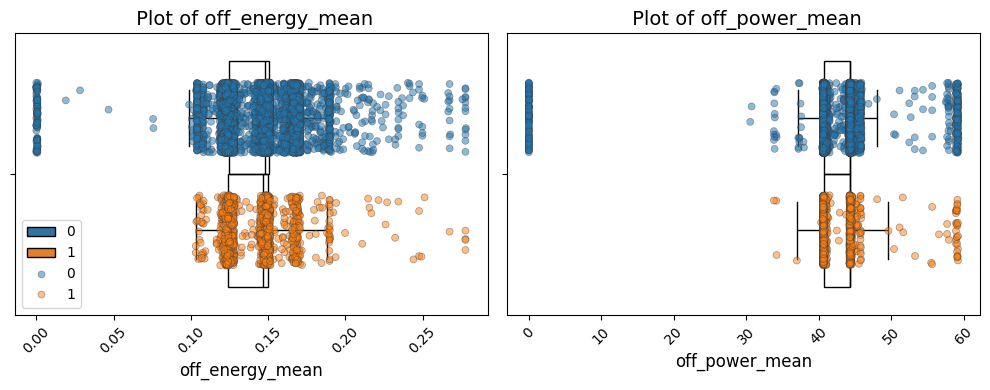

In [ ]:
cols = [1, 13]
jitter_box_plot(data = p, feature_indices = cols, category = None, cat = 'churn', rows = 1, cols = 2)

In [ ]:

p['forecasted_peak_energy_change'] = p['forecast_price_energy_peak'] - p['peak_mean']
p['forecasted_off_power_change'] = p['forecast_price_pow_off_peak'] - p['off_power_mean']
p['forecasted_off_energy_change'] = p['forecast_price_energy_off_peak'] - p['off_energy_mean']


p['forecasted_peak_energy_change'] = np.where(p['forecasted_peak_energy_change'] > 0, "Inc", np.where(p['forecasted_peak_energy_change'] < 0, "Dec", "Same"))
p['forecasted_off_power_change'] = np.where(p['forecasted_off_power_change'] > 0, "Inc", np.where(p['forecasted_off_power_change'] < 0, "Dec", "Same"))
p['forecasted_off_energy_change'] = np.where(p['forecasted_off_energy_change'] > 0, "Inc", np.where(p['forecasted_off_energy_change'] < 0, "Dec", "Same"))


p['forecasted_peak_energy_change'] = p['forecasted_peak_energy_change'].map(change_map)
p['forecasted_off_power_change'] = p['forecasted_off_power_change'].map(change_map)
p['forecasted_off_energy_change'] = p['forecasted_off_energy_change'].map(change_map)


In [ ]:
p = p.drop(['peak_fix_mean', 'peak_fix_max', 'peak_fix_price_change', 'mid_fix_mean', 'mid_fix_max',
            'mid_fix_price_change', 'peak_fix_std', 'mid_fix_std','peak_mean', 'peak_std', 'peak_max',
            'peak_price_change', 'mid_peak_mean', 'mid_peak_std', 'mid_peak_max','mid_peak_price_change',
           'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'forecast_price_energy_off_peak'], axis =1)

In [ ]:
get_kmeans_thresholds(p, 'off_energy_mean', 6)

"off_energy_mean cluster thresholds"
[np.float64(0.053696224830753495), np.float64(0.11505536204546446), np.float64(0.13642242245348785), np.float64(0.15935996753668158), np.float64(0.2036048823434568)]


In [ ]:
p['off_energy_price_level'] = np.where( p['off_energy_mean'] == 0, 'FREE',
                       np.where(p['off_energy_mean'] < 0.115, 'LOW',
                       np.where(p['off_energy_mean'] < 0.136, 'MEDIUM',
                       np.where(p['off_energy_mean'] < 0.159, 'ABOVE_MEDIUM',
                       np.where(p['off_energy_mean'] < 0.2036, 'HIGH', 'ABOVE_HIGH')))))

level_map_off_energy = {'FREE': 0, 'LOW': 1, 'MEDIUM': 2, 'ABOVE_MEDIUM': 3, 'HIGH': 4, 'ABOVE_HIGH': 5}
p['off_energy_price_level'] = p['off_energy_price_level'].map(level_map_off_energy)

In [ ]:
p['off_energy_price_change'] = np.where(p['off_energy_price_change'] > 0, "Dec", np.where(p['off_energy_price_change'] < 0, "Inc", "Same"))
p['off_power_price_change'] = np.where(p['off_power_price_change'] > 0, "Dec", np.where(p['off_power_price_change'] < 0, "Inc", "Same"))

p['off_energy_price_change'] = p['off_energy_price_change'].map(change_map)
p['off_power_price_change'] = p['off_power_price_change'].map(change_map)

In [ ]:
get_kmeans_thresholds(p, 'off_power_mean', 6)

"off_power_mean cluster thresholds"
[np.float64(17.539390079500038), np.float64(37.88397245255878), np.float64(42.54097217160485), np.float64(48.74136948484236), np.float64(56.01172732343916)]


In [ ]:
p['off_power_price_level'] = np.where( p['off_power_mean'] == 0, 'FREE',
                       np.where(p['off_power_mean'] < 37.88, 'LOW',
                       np.where(p['off_power_mean'] < 42.54, 'MEDIUM',
                       np.where(p['off_power_mean'] < 48.74, 'ABOVE_MEDIUM',
                       np.where(p['off_power_mean'] < 56.012, 'HIGH', 'ABOVE_HIGH')))))

level_map_off_power = {'FREE': 0, 'LOW': 1, 'MEDIUM': 2, 'ABOVE_MEDIUM': 3, 'HIGH': 4, 'ABOVE_HIGH': 5}
p['off_power_price_level'] = p['off_power_price_level'].map(level_map_off_power)

In [ ]:
p = p.drop(['off_power_mean', 'off_power_max', 'off_energy_mean', 'off_energy_max', 'off_energy_std', 'off_power_std'], axis = 1)

In [ ]:
p['date_activ'] = pd.to_datetime(p['date_activ'])
p['date_end'] = pd.to_datetime(p['date_end'])
p['date_modif_prod'] = pd.to_datetime(p['date_modif_prod'])
p['date_renewal'] = pd.to_datetime(p['date_renewal'])

In [ ]:
print(p['date_activ'].describe())
print(p['date_end'].describe())
print(p['date_modif_prod'].describe())
print(p['date_renewal'].describe())

count                            14606
mean     2011-01-28 07:54:18.879912448
min                2003-05-09 00:00:00
25%                2010-01-15 00:00:00
50%                2011-03-04 00:00:00
75%                2012-04-19 00:00:00
max                2014-09-01 00:00:00
Name: date_activ, dtype: object
count                            14606
mean     2016-07-27 20:48:26.422018560
min                2016-01-28 00:00:00
25%                2016-04-27 06:00:00
50%                2016-08-01 00:00:00
75%                2016-10-31 00:00:00
max                2017-06-13 00:00:00
Name: date_end, dtype: object
count                            14606
mean     2013-01-02 12:29:10.951663616
min                2003-05-09 00:00:00
25%                2010-08-12 00:00:00
50%                2013-06-19 00:00:00
75%                2015-06-16 00:00:00
max                2016-01-29 00:00:00
Name: date_modif_prod, dtype: object
count                            14606
mean     2015-07-21 06:59:00.353279488
min 

In [ ]:
p['tenure_days'] = ((p['date_end'] - p['date_activ']).dt.days).astype(int)
p['days_since_modif'] = (p['date_end'] - p['date_modif_prod']).dt.days
p['months_renewal'] = ((p['date_end'] - p['date_renewal']).dt.days / 30.4375).astype(int)
p = p.drop(['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'],axis = 1)

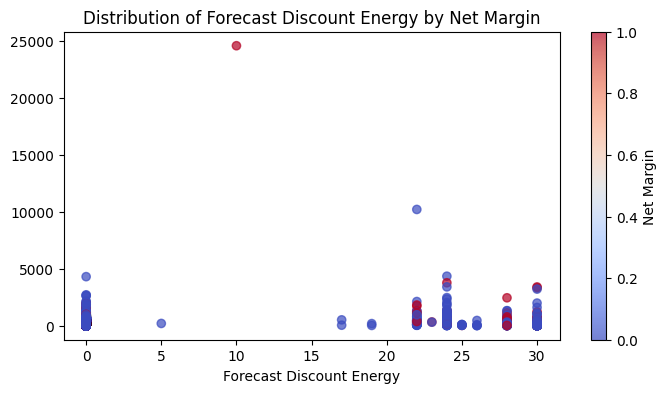

In [ ]:
plt.figure(figsize=(8, 4))
scatter = plt.scatter(p["forecast_discount_energy"], p['net_margin'],  c=p["churn"], cmap="coolwarm", alpha=0.7)
plt.colorbar(scatter, label="Net Margin")
plt.xlabel("Forecast Discount Energy")
plt.title("Distribution of Forecast Discount Energy by Net Margin")
plt.show()

In [ ]:
get_kmeans_thresholds(p, 'forecast_discount_energy', 3)

"forecast_discount_energy cluster thresholds"
[np.float64(11.652559092861232), np.float64(26.370259071225867)]


In [ ]:
p['forecast_discount_energy'] = p['forecast_discount_energy'].apply(lambda x: "low" if 0 <= x < 12 else "med" if 15 <= x < 26.37 else "high")

In [ ]:
p = p.drop('margin_gross_pow_ele',axis = 1)

**Forecasted change in consumption over 12 months has ben calculated and added as a new column**

In [ ]:
p['forecast_power_cons_change'] = p['forecast_cons_12m'] - p['cons_12m']
p['forecast_power_cons_change'] = p['forecast_power_cons_change'].apply(lambda x: "Dec" if x<0 else "Same" if  x == 0 else "Inc")
p['forecast_power_cons_change'] = p['forecast_power_cons_change'].map(change_map)
p = p.drop(['forecast_cons_12m', 'forecast_cons_year'],axis=1)

**THE INCOSISTENT ENTRIES WITH HAS_GAS AS 'FALSE' BUT POSITIVE GAS CONSUMPTION ARE REPLACED TO 'TRUE'**

In [ ]:
p.loc[(p['has_gas'] == 'f') & (p['cons_gas_12m'] > 0), 'has_gas'] = 't'

In [ ]:
# Crosstab: has_gas vs churn
print("Crosstab: has_gas vs churn")
print(pd.crosstab(p['has_gas'], p['churn']))

# Crosstab: origin_up vs churn
print("\nCrosstab: origin_up vs churn")
print(pd.crosstab(p['origin_up'], p['churn']))

# Crosstab: channel_sales vs churn
print("\nCrosstab: channel_sales vs churn")
print(pd.crosstab(p['channel_sales'], p['churn']))


Crosstab: has_gas vs churn
churn        0     1
has_gas             
f        10714  1188
t         2473   231

Crosstab: origin_up vs churn
churn                                0    1
origin_up                                  
MISSING                             60    4
ewxeelcelemmiwuafmddpobolfuxioce     1    0
kamkkxfxxuwbdslkwifmmcsiusiuosws  4036  258
ldkssxwpmemidmecebumciepifcamkci  2884  264
lxidpiddsbxsbosboudacockeimpuepw  6204  893
usapbepcfoloekilkwsdiboslwaxobdp     2    0

Crosstab: channel_sales vs churn
churn                                0    1
channel_sales                              
MISSING                           3442  283
epumfxlbckeskwekxbiuasklxalciiuu     3    0
ewpakwlliwisiwduibdlfmalxowmwpci   818   75
fixdbufsefwooaasfcxdxadsiekoceaa     2    0
foosdfpfkusacimwkcsosbicdxkicaua  5934  820
lmkebamcaaclubfxadlmueccxoimlema  1740  103
sddiedcslfslkckwlfkdpoeeailfpeds    11    0
usilxuppasemubllopkaafesmlibmsdf  1237  138


In [ ]:
excluded_origin = ['MISSING', 'ewxeelcelemmiwuafmddpobolfuxioce', 'usapbepcfoloekilkwsdiboslwaxobdp']
p = p[~p['origin_up'].isin(excluded_origin)]

In [ ]:
excluded_channel = ['epumfxlbckeskwekxbiuasklxalciiuu', 'fixdbufsefwooaasfcxdxadsiekoceaa', 'sddiedcslfslkckwlfkdpoeeailfpeds']
p = p[~p['channel_sales'].isin(excluded_channel)]

- cons_12m = electricity consumption of the past 12 months
- cons_gas_12m = gas consumption of the past 12 months
- cons_last_month = electricity consumption of the last month

- forecast_cons_12m = forecasted electricity consumption for next 12 months
- forecast_cons_year = forecasted electricity consumption for the next calendar year

- forecast_meter_rent_12m = forecasted bill of meter rental for the next 2 months


- imp_cons = current paid consumption
- margin_gross_pow_ele = gross margin on power subscription
- margin_net_pow_ele = net margin on power subscription
- nb_prod_act = number of active products and services
- net_margin = total net margin
- num_years_antig = antiquity of the client (in number of years)

- pow_max = subscribed power


In [ ]:
cols = [4, 5, 6, 10, 11, 13, 16]
p.iloc[:,cols].describe()

,cons_12m,cons_gas_12m,cons_last_month,imp_cons,margin_net_pow_ele,net_margin,pow_max
count,1.452300e+04,1.452300e+04,14523.000000,14523.000000,14523.000000,14523.000000,14523.000000
mean,1.596212e+05,2.817860e+04,16128.206775,152.249526,24.542801,188.901462,18.113618
std,5.744984e+05,1.633748e+05,64479.038492,339.203242,20.204598,311.160615,13.425678
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,3.300000
25%,5.675500e+03,0.000000e+00,0.000000,0.000000,14.265000,50.680000,12.500000
50%,1.411800e+04,0.000000e+00,794.000000,37.390000,21.640000,112.480000,13.856000
75%,4.076850e+04,0.000000e+00,3383.000000,193.905000,29.850000,242.680000,19.075000
max,6.207104e+06,4.154590e+06,771203.000000,15042.790000,374.640000,24570.650000,320.000000


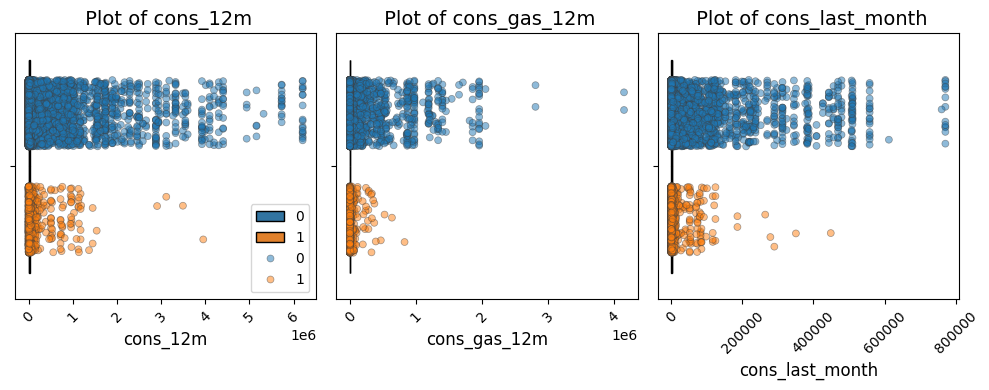

In [ ]:
cols = [4, 5, 6]
jitter_box_plot(data = p, feature_indices = cols, category = None, cat = 'churn', rows = 1, cols = 3)

In [ ]:
p[p['net_margin'] > 5000]

,id,off_energy_price_change,off_power_price_change,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_discount_energy,forecast_meter_rent_12m,has_gas,...,mid_peak_power_price_level,forecasted_peak_energy_change,forecasted_off_power_change,forecasted_off_energy_change,off_energy_price_level,off_power_price_level,tenure_days,days_since_modif,months_renewal,forecast_power_cons_change
11847,d00e8a9951b5551d8f02e45f9ed2b0dd,1,-1,foosdfpfkusacimwkcsosbicdxkicaua,290003,0,18812,med,166.96,f,...,3,-1,1,-1,4,2,1480,731,11,-1
14345,fb7dcb0f4e0dc4ee54874eab2607c4da,1,-1,foosdfpfkusacimwkcsosbicdxkicaua,558553,352618,43290,low,348.01,t,...,1,1,1,-1,3,5,1465,731,11,-1


In [ ]:
p = p[p['net_margin'] < 5000]

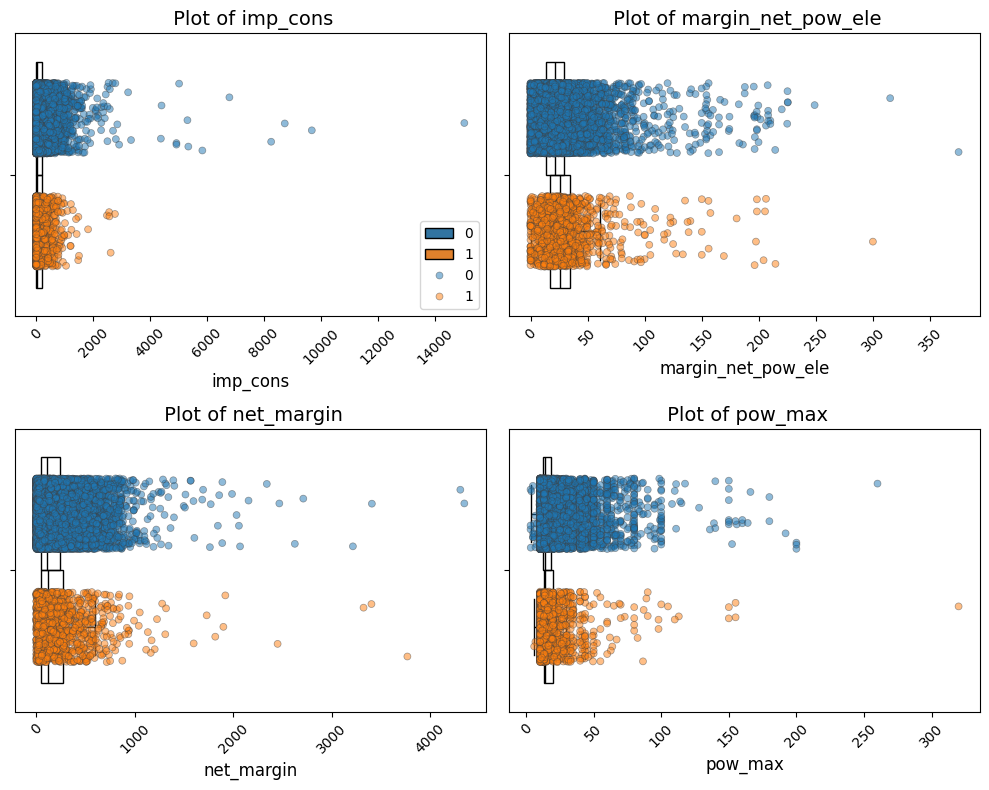

In [ ]:
cols = [10, 11, 13, 16]
jitter_box_plot(data = p, feature_indices = cols, category = None, cat = 'churn', rows = 2, cols = 2)

In [ ]:
p = p[p['nb_prod_act'] < 30]

# MODEL FITTING

In [ ]:
data = p.copy()

In [ ]:
data = data.drop(['origin_up', 'channel_sales', 'num_years_antig'], axis = 1)

In [ ]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category')

In [ ]:
for col in data.columns:
    if data[col].dtype == 'bool':
        data[col] = data[col].astype('int64')

In [ ]:
X = data.drop(columns=["churn", "id"])
y = data["churn"]
X = pd.get_dummies(X, drop_first=True)

for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(y.value_counts(normalize=True))

churn
0    0.902617
1    0.097383
Name: proportion, dtype: float64


In [ ]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb_model = xgb.XGBClassifier( objective="binary:logistic", eval_metric="logloss", n_estimators=1000, learning_rate=0.05,
    max_depth=5, subsample=0.8, scale_pos_weight=scale_pos_weight, gamma=3, min_child_weight=5, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list = []
conf_matrices = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"\n🔹 Fold {fold}")
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_fold)
    model = xgb_model
    model.fit(X_train_fold, y_train_fold, sample_weight=sample_weights)
    y_pred_proba_fold = model.predict_proba(X_val_fold)[:, 1]
    y_pred_adjusted_fold = (y_pred_proba_fold > 0.5).astype(int)
    accuracy = accuracy_score(y_val_fold, y_pred_adjusted_fold)
    accuracy_list.append(accuracy)
    conf_matrix = confusion_matrix(y_val_fold, y_pred_adjusted_fold)
    conf_matrices.append(conf_matrix)

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_report(y_val_fold, y_pred_adjusted_fold))

print("\n **Cross-Validation Results:**")
print(f"Average Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
avg_conf_matrix = np.mean(conf_matrices, axis=0)
print("\n**Average Confusion Matrix Across Folds:**\n", avg_conf_matrix)



🔹 Fold 1
Accuracy: 0.6309
Confusion Matrix:
 [[1677  945]
 [ 127  155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76      2622
           1       0.14      0.55      0.22       282

    accuracy                           0.63      2904
   macro avg       0.54      0.59      0.49      2904
weighted avg       0.85      0.63      0.71      2904


🔹 Fold 2
Accuracy: 0.6381
Confusion Matrix:
 [[1688  933]
 [ 118  165]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.64      0.76      2621
           1       0.15      0.58      0.24       283

    accuracy                           0.64      2904
   macro avg       0.54      0.61      0.50      2904
weighted avg       0.86      0.64      0.71      2904


🔹 Fold 3
Accuracy: 0.6470
Confusion Matrix:
 [[1712  909]
 [ 116  167]]
Classification Report:
               precision    recall  f1-score   support



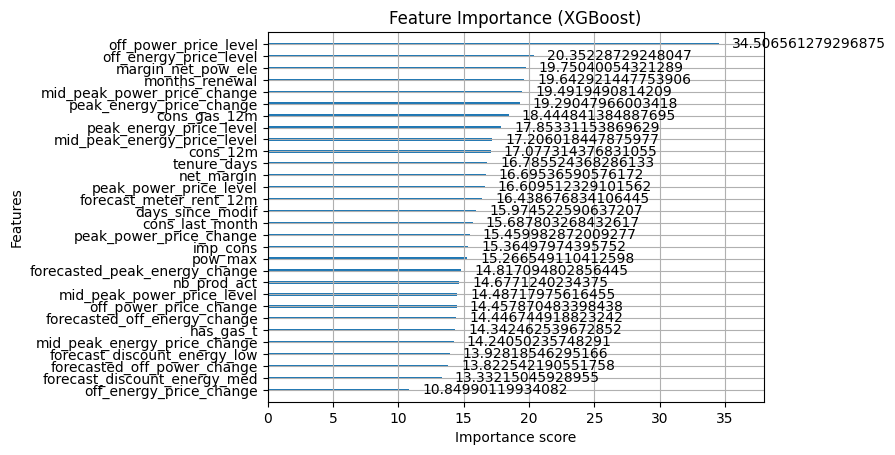

In [ ]:
xgb.plot_importance(model, importance_type='gain', max_num_features=30)  # Show top 15 features
plt.title("Feature Importance (XGBoost)")
plt.show()

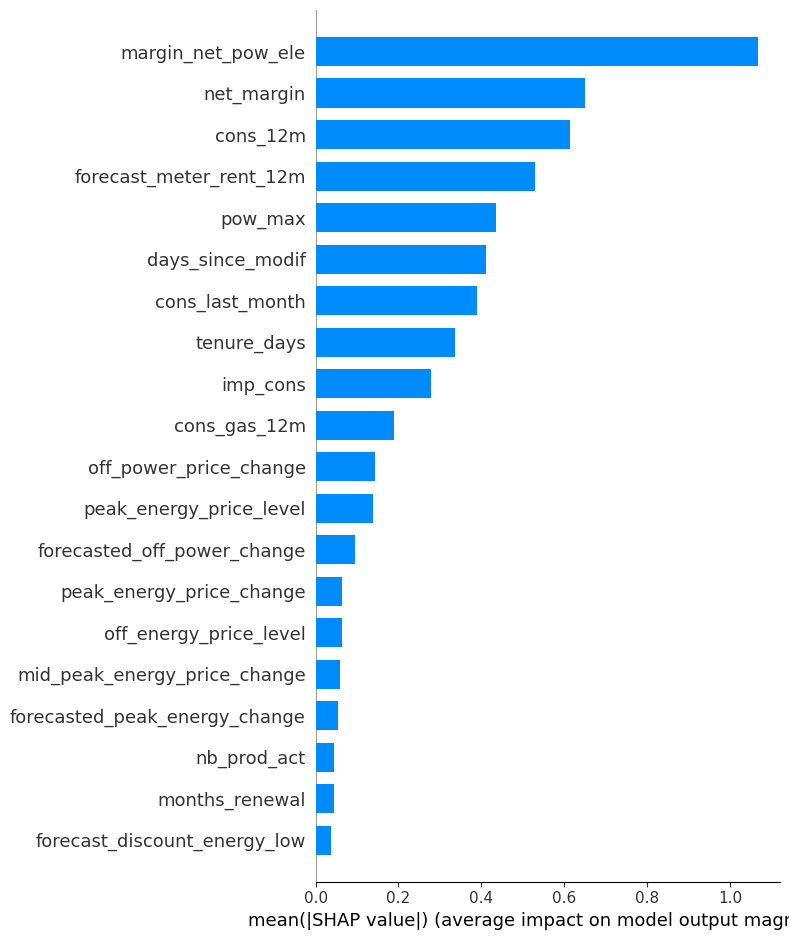

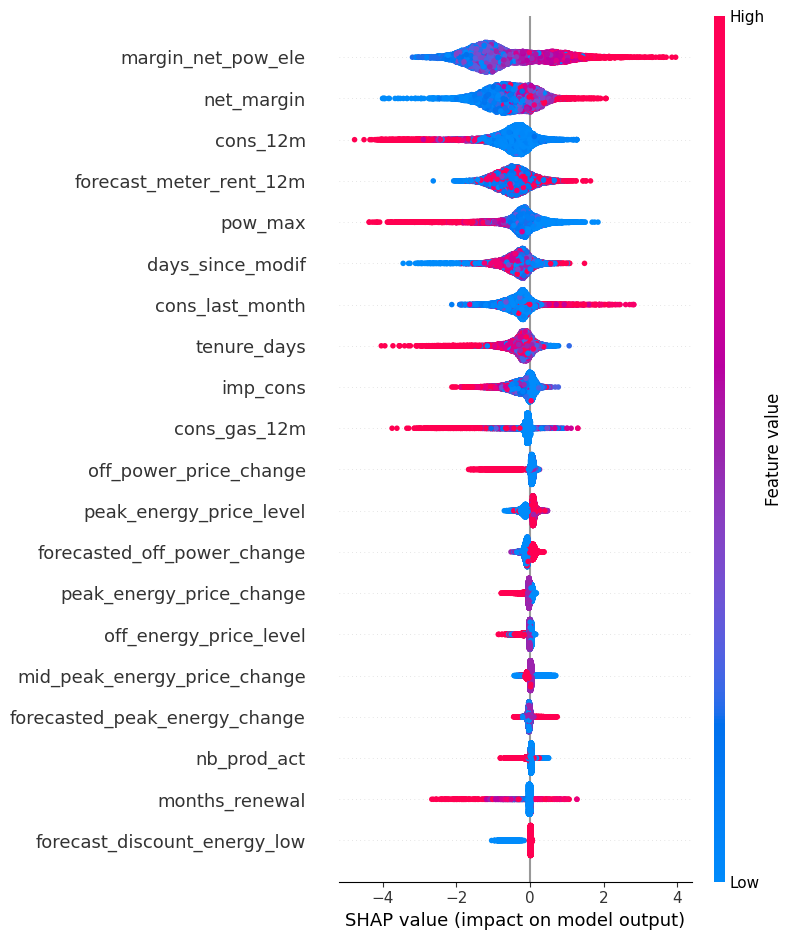

In [ ]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)

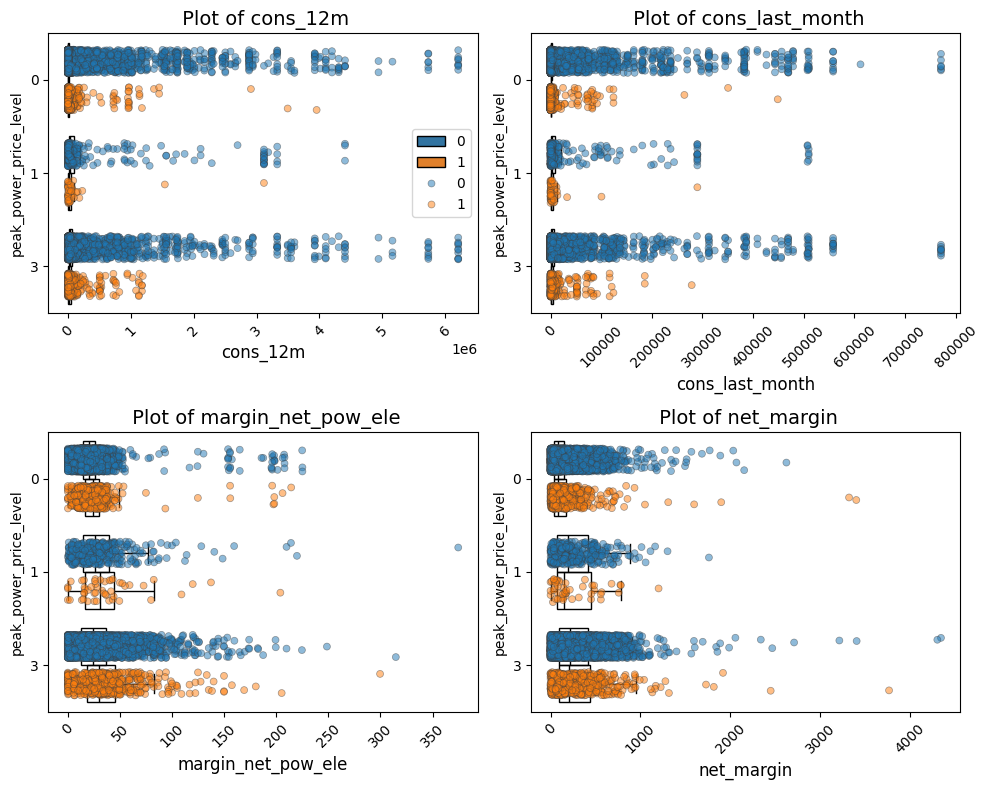

In [ ]:
a = p.copy()
a['peak_power_price_level'] = a['peak_power_price_level'].astype('category')
jitter_box_plot(a,[4, 6, 11, 13] , category='peak_power_price_level', cat='churn', rows=2, cols= 2)

**More dependent Clients are prone to stay**

Those clients with higher consumption are prone to stay

Clients with less margin have more churn rates.


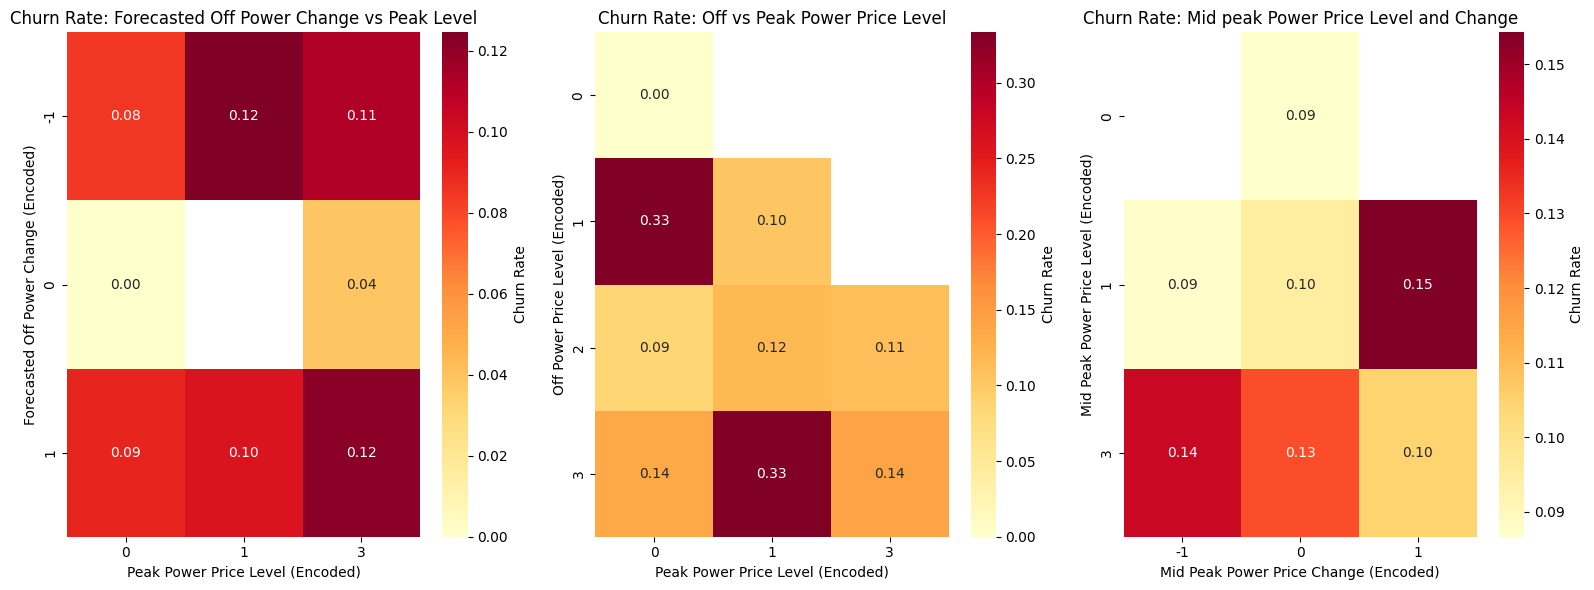

In [ ]:
a['forecasted_off_power_change'] = a['forecasted_off_power_change'].astype('category')
a['off_power_price_level'] = a['off_power_price_level'].astype('category')
a['peak_power_price_level'] = a['peak_power_price_level'].astype('category')
a['mid_peak_power_price_level'] = a['mid_peak_power_price_level'].astype('category')
a['mid_peak_power_price_change'] = a['mid_peak_power_price_change'].astype('category')

heatmap1 = a.pivot_table(index='forecasted_off_power_change', columns='peak_power_price_level', values='churn', aggfunc='mean', observed = False)
heatmap2 = a.pivot_table(index='off_power_price_level', columns='peak_power_price_level', values='churn', aggfunc='mean', observed = False)
heatmap3 = a.pivot_table(index='mid_peak_power_price_level', columns='mid_peak_power_price_change', values='churn', aggfunc='mean', observed = False)

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
sns.heatmap(heatmap1, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Churn Rate'}, ax=axes[0])
axes[0].set_title("Churn Rate: Forecasted Off Power Change vs Peak Level")
axes[0].set_xlabel("Peak Power Price Level (Encoded)")
axes[0].set_ylabel("Forecasted Off Power Change (Encoded)")

sns.heatmap(heatmap2, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Churn Rate'}, ax=axes[1])
axes[1].set_title("Churn Rate: Off vs Peak Power Price Level")
axes[1].set_xlabel("Peak Power Price Level (Encoded)")
axes[1].set_ylabel("Off Power Price Level (Encoded)")

sns.heatmap(heatmap3, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Churn Rate'}, ax=axes[2])
axes[2].set_title("Churn Rate: Mid peak Power Price Level and Change")
axes[2].set_xlabel("Mid Peak Power Price Change (Encoded)")
axes[2].set_ylabel("Mid Peak Power Price Level (Encoded)")

plt.tight_layout()
plt.show()

**Stability of Prices may be required**

When forecasted off-power change is stable (0), churn is lowest across all peak price levels — as low as 0.00 or 0.04.

As soon as off-power usage is forecasted to increase (1) or decrease (-1), the churn rate increases.

Highest churn happens when there's price instability (±1) combined with moderate-to-high peak price levels.

**Customers are more likely to churn when they anticipate changes in their off-peak consumption regardless of whether it’s an increase or decrease. This implies they might be responding to volatility or uncertainty, not just the direction of change.**

**Churn rate may be dependent on the interaction between peak and off-peak pricing tiers**

There is clear interaction between the two categorical variables:

At fixed off-level = 1, churn changes drastically across peak levels (0.33 → 0.10).

At off-level = 3, churn is highest at peak = 1 but lower at other peak levels.

**Customers may perceive inconsistencies in pricing tiers — for example, paying mid/high off-peak rates but not getting proportionally lower peak prices can feel unfair, driving churn.**

Those clients with low mid peak prices have increasing churn rate with incresing mid peak price but with high mid peak prices it is opposite. The reason may be due to other factors.

**Stability and proper structure of power prices may be a concern**

## SURVIVAL MODELLING

In [ ]:
df = data.copy()
df = df.drop(columns=['id'])
df = pd.get_dummies(df, drop_first=True)
cph = CoxPHFitter()
cph.fit(df, duration_col='tenure_days', event_col='churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 14520 total observations, 13106 right-censored observations>
             duration col = 'tenure_days'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 14520
number of events observed = 1414
   partial log-likelihood = -12276.82
         time fit was run = 2025-08-04 06:59:10 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
off_energy_price_change        0.11      1.11      0.10           -0.09            0.31                0.91                1.36
off_power_price_change        -0.13      0.87      0.04           -0.22           -0.05                0.80                0.95
cons_12m                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
cons_gas_12m                  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
cons_last_month                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
forecast_meter_rent_12m        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
imp_cons                      -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
margin_net_pow_ele             0.02      1.02      0.00            0.02            0.02                1.02                1.02
nb_prod_act                   -0.01      0.99      0.07           -0.15            0.14                0.86                1.15
net_margin                     0.00      1.00      0.00            0.00            0.00                1.00                1.00
pow_max                       -0.02      0.98      0.00           -0.03           -0.01                0.97                0.99
peak_energy_price_change       0.00      1.00      0.08           -0.15            0.15                0.86                1.17
mid_peak_energy_price_change  -0.07      0.93      0.05           -0.17            0.03                0.84                1.03
peak_power_price_change       -0.36      0.70      0.22           -0.80            0.07                0.45                1.08
mid_peak_power_price_change    0.24      1.27      0.23           -0.20            0.68                0.82                1.98
peak_energy_price_level        0.12      1.13      0.09           -0.06            0.30                0.94                1.35
mid_peak_energy_price_level   -0.56      0.57      0.19           -0.92           -0.19                0.40                0.83
peak_power_price_level         0.04      1.04      0.22           -0.40            0.48                0.67                1.62
mid_peak_power_price_level     0.35      1.42      0.16            0.03            0.68                1.03                1.97
forecasted_peak_energy_change  0.05      1.05      0.07           -0.10            0.20                0.91                1.22
forecasted_off_power_change   -0.17      0.84      0.03           -0.23           -0.11                0.79                0.90
forecasted_off_energy_change  -0.23      0.80      0.12           -0.46            0.01                0.63                1.01
off_energy_price_level        -0.26      0.77      0.10           -0.45           -0.06                0.64                0.94
off_power_price_level          0.28      1.32      0.13            0.03            0.54                1.03                1.71
days_since_modif              -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
months_renewal                -0.01      0.99      0.02           -0.04            0.02                0.96                1.02
forecast_power_cons_change    -0.22      0.

***CHECKING THE PROPORTIONAL HAZARDS ASSUMPTION***

In [ ]:
cph.check_assumptions(df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 14520 total observations, 13106 right-censored observations>
         test_name = proportional_hazard_test

---
                                    test_statistic      p  -log2(p)
cons_12m                      km              1.00   0.32      1.66
                              rank            0.56   0.45      1.14
cons_gas_12m                  km              0.03   0.85      0.23
                              rank            0.06   0.80      0.32
cons_last_month               km              0.78   0.38      1.41
                              rank            0.60   0.44      1.19
days_since_modif              km            139.44 <0.005    104.48
                              rank          112.01 <0.005     84.54
forecast_discount_energy_low  km              2.78   0.10      3.39
                              rank            6.97   0.01      6.92
forecast_discount_energy_med  km              0.00   1.00      0.00
                              rank            0.00   1.00      0.00
forecast_meter_rent_12m       km              3.44   0.06      3.97
                              rank            5.92   0.01      6.06
forecast_power_cons_change    km              2.32   0.13      2.97
                              rank            3.24   0.07      3.80
forecasted_off_energy_change  km              0.35   0.55      0.86
                              rank            0.17   0.68      0.55
forecasted_off_power_change   km             14.88 <0.005     13.09
                              rank           18.10 <0.005     15.54
forecasted_peak_energy_change km              0.39   0.53      0.92
                              rank            0.85   0.36      1.49
has_gas_t                     km              0.09   0.77      0.38
                              rank            0.00   0.99      0.01
imp_cons                      km              0.94   0.33      1.59
                              rank            1.59   0.21      2.27
margin_net_pow_ele            km              2.83   0.09      3.43
                              rank            4.73   0.03      5.08
mid_peak_energy_price_change  km             13.40 <0.005     11.95
                              rank           17.67 <0.005     15.21
mid_peak_energy_price_level   km              3.07   0.08      3.65
                              rank            5.61   0.02      5.80
mid_peak_power_price_change   km              0.00   0.95      0.08
                              rank            0.07   0.79      0.35
mid_peak_power_price_level    km              0.37   0.54      0.88
                              rank            0.56   0.46      1.13
months_renewal                km              0.13   0.72      0.48
                              rank            0.16   0.69      0.54
nb_prod_act                   km              0.87   0.35      1.52
                              rank            2.64   0.10      3.26
net_margin                    km              0.81   0.37      1.44
                              rank            0.23   0.64      0.66
off_energy_price_change       km              0.28   0.59      0.75
                              rank            1.20   0.27      1.87
off_energy_price_level        km              0.24   0.62      0.68
                              rank            0.04   0.84      0.26
off_power_price_change        km              0.65   0.42      1.26
                              rank            0.02   0.90      0.15
off_power_price_level         km              0.02   0.90      0.16
                              rank            0.00   0.97      0.05
peak_energy_price_change      km              0.22   0.64      0.65
                              rank            0.17   0.68      0.56
peak_energy_price_level       km              2.76   0.10      3.37
                              rank            1



1. Variable 'forecast_meter_rent_12m' failed the non-proportional test: p-value is 0.0150.

   Advice 1: the functional form of the variable 'forecast_meter_rent_12m' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'forecast_meter_rent_12m' using pd.cut, and then specify it in
`strata=['forecast_meter_rent_12m', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'margin_net_pow_ele' failed the non-proportional test: p-value is 0.0296.

   Advice 1: the functional form of the variable 'margin_net_pow_ele' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect func

[]

**The Survival model has an concordance index of 0.72, indicating decent performance.**

**But some of the covariates failed the proportional hazards assumption. So one way out is to fit the Cox model by stratifying across those covariates.**

In [ ]:
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


for col in ['mid_peak_energy_price_change', 'mid_peak_energy_price_level', 'forecasted_off_power_change', 'forecast_discount_energy_low']:
    df[col] = df[col].astype("category")


data1 = df.drop(columns='id', errors='ignore')

cph = CoxPHFitter()
cph.fit(data1, duration_col='tenure_days', event_col='churn', strata=['mid_peak_energy_price_change', 'mid_peak_energy_price_level',
                                                                      'forecasted_off_power_change', 'forecast_discount_energy_low'])
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 14520 total observations, 13106 right-censored observations>
             duration col = 'tenure_days'
                event col = 'churn'
                   strata = ['mid_peak_energy_price_change', 'mid_peak_energy_price_level', 'forecasted_off_power_change', 'forecast_discount_energy_low']
      baseline estimation = breslow
   number of observations = 14520
number of events observed = 1414
   partial log-likelihood = -9593.75
         time fit was run = 2025-08-04 06:59:28 UTC

---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                      
off_energy_price_change       -0.08      0.92      0.10           -0.28            0.12                0.75                1.13
off_power_price_change        -0.12      0.89      0.05           -0.21           -0.02                0.81                0.98
cons_12m                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
cons_gas_12m                  -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
cons_last_month                0.00      1.00      0.00           -0.00            0.00                1.00                1.00
forecast_meter_rent_12m        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
imp_cons                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
margin_net_pow_ele             0.02      1.02      0.00            0.02            0.03                1.02                1.03
nb_prod_act                   -0.02      0.99      0.08           -0.16            0.13                0.85                1.14
net_margin                     0.00      1.00      0.00            0.00            0.00                1.00                1.00
pow_max                       -0.03      0.97      0.00           -0.03           -0.02                0.97                0.98
peak_energy_price_change       0.09      1.10      0.08           -0.07            0.25                0.94                1.28
peak_power_price_change        0.06      1.06      0.22           -0.38            0.50                0.69                1.65
mid_peak_power_price_change   -0.18      0.84      0.23           -0.62            0.27                0.54                1.32
peak_energy_price_level        0.10      1.10      0.11           -0.12            0.32                0.89                1.37
peak_power_price_level         0.70      2.01      0.28            0.15            1.25                1.16                3.49
mid_peak_power_price_level    -0.45      0.64      0.23           -0.89           -0.01                0.41                0.99
forecasted_peak_energy_change  0.03      1.03      0.08           -0.13            0.18                0.88                1.20
forecasted_off_energy_change  -0.34      0.71      0.13           -0.60           -0.08                0.55                0.92
off_energy_price_level        -0.25      0.78      0.12           -0.49           -0.01                0.61                0.99
off_power_price_level         -0.15      0.86      0.17           -0.48            0.18                0.62                1.20
days_since_modif              -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
months_renewal                -0.02      0.98      0.02           -0.05            0.02                0.95                1.02
forecast_power_cons_change     0.00      1.00      0.27           -0.52            0.52                0.60                1.69
forecast_discount_energy_med  -0.37      0.69      0.41           -1.17            0.43                0.31                1.53
has_gas_t        

## INTERPRETATION AND CONCLUSIONS

### 🔍 Interpretation of Statistically Significant Covariates (p < 0.05)

#### ⚡ Consumption & Pricing Features

- **`off_power_price_change`** ↓ (HR = 0.89, p = 0.02)
  - *Business Insight*: Customers are **less likely to churn** when off-peak power prices **decrease**.
  - *Statistical Insight*: A 1-unit price drop is associated with an 11% decrease in churn hazard.

- **`cons_gas_12m`** ↓ (HR ≈ 1.00, p < 0.005)
  - *Business Insight*: Small negative relationship—**higher gas usage slightly improves retention**.
  - *Statistical Insight*: Although the effect is small, the relationship is statistically robust.

- **`imp_cons`** ↓ (HR ≈ 1.00, p = 0.05)
  - *Business Insight*: **Imputed consumption inversely relates to churn**—possible indicator of billing issues or system estimates.
  - *Statistical Insight*: Marginal but significant negative association.

#### 💰 Margin & Profitability

- **`margin_net_pow_ele`** ↑ (HR = 1.02, p < 0.005)
  - *Business Insight*: Higher margin on electricity supply **slightly increases churn**—likely due to high pricing or low value perception.
  - *Statistical Insight*: 2% increase in churn hazard per unit margin increase.

- **`net_margin`** ↑ (HR = 1.00, p < 0.005)
  - *Business Insight*: Even small increases in overall margin **may contribute to churn**—possibly due to perceived unfair billing.
  - *Statistical Insight*: Statistically significant despite small magnitude.

#### 🔌 Usage & Capacity

- **`pow_max`** ↓ (HR = 0.98, p < 0.005)
  - *Business Insight*: Customers with higher max power usage are **less likely to churn**—possibly more dependent or loyal.
  - *Statistical Insight*: Each unit increase in `pow_max` reduces hazard by ~2%.

#### 📈 Pricing Levels

- **`peak_power_price_level`** ↑ (HR = 1.98, p < 0.005)
  - *Business Insight*: Higher peak power prices **strongly push users toward churn**.
  - *Statistical Insight*: Nearly **double the hazard** of churn at high peak price levels.

- **`mid_peak_power_price_level`** ↓ (HR = 0.49, p < 0.005)
  - *Business Insight*: Mid-peak power pricing **appears protective**—possibly perceived as fair or affordable.
  - *Statistical Insight*: Associated with **51% reduced churn hazard**.

#### 🧮 Recency of Interaction

- **`days_since_modif`** ↓ (HR ≈ 1.00, p < 0.005)
  - *Business Insight*: **Recent product modifications reduce churn**—showing that engagement and updates retain customers.
  - *Statistical Insight*: Although HR ≈ 1, it's statistically highly significant due to large sample size.

### 🧾 Key Conclusion: Price Sensitivity Drives Customer Churn

- 🟢 **Customers show high sensitivity to electricity pricing**, especially during **peak and mid-peak hours**.
- 🔺 Variables like `margin_net_pow_ele`, `net_margin`, and `peak_power_price_level` significantly increase churn risk, highlighting **pricing pressure**.
- 📉 Conversely, variables like `pow_max` and `off_power_price_change` show **retention among large or off-peak users**, but still imply pricing influences.
- 📊 Our analysis supports **segmenting users by usage and price tiers**, and developing **flexible pricing plans** or **loyalty benefits** to mitigate churn risk.

✅ **Recommendation**: Monitor price elasticity closely and integrate pricing feedback into retention strategies.
